In [1]:
%pip install captcha 
%pip install opencv-python
!apt update && apt install -y libsm6 libxext6
!pip install opencv-python-headless
!pip install opencv-contrib-python-headless
%pip install keras


import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha

import itertools

import os
import cv2
import numpy as np
from random import random, randint, choices

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


'apt' is not recognized as an internal or external command,
operable program or batch file.


Note: you may need to restart the kernel to use updated packages.


In [2]:
def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        print('generating %d/%d' % (counter + 1, num_of_repetition))
        for i in itertools.permutations([str(c) for c in range(10)], num_of_letters):
            captcha = ''.join(i)
            fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
            image.write(captcha, fn)


def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [3]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 4
EPOCHS = 50
IMG_ROW, IMG_COLS = 50, 150


# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'generated_captcha')

In [30]:
def load_data(path, test_split=0.1, width=IMG_COLS, height=IMG_ROW):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, 10))
                for i in range(NUM_OF_LETTERS):
                    label[i, int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(width/2), int(height/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


In [6]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 8 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

In [31]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 40320 (train=36423, test=3897)


In [32]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(36423, 25, 75, 1)
(36423, 4, 10)
(3897, 25, 75, 1)
(3897, 4, 10)


In [33]:
s_train = []
s_test = []
for i in range(NUM_OF_LETTERS):
    s_train.append(y_train[:, i, :])
    s_test.append(y_test[:, i, :])

In [34]:
save_dir = os.path.join(PATH, 'saved_models')
model_name = 'keras_cifar10_trained_4digits_model.h5'

In [36]:
input_layer = Input((int(IMG_ROW/2), int(IMG_COLS/2), 1))
x = Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=48, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

out = [Dense(10, name='digit%d' % i, activation='softmax')(x) for i in range(NUM_OF_LETTERS)]
model = Model(inputs=input_layer, outputs=out)

In [11]:
# Uncomment these if you want to load and continue an already trained network

# model_path = os.path.join(save_dir, model_name)
# model = keras.models.load_model(model_path)

In [37]:
# initiate Adam optimizer

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 25, 75, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 25, 75, 32)   832         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 12, 37, 32)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 12, 37, 48)   38448       max_pooling2d_3[0][0]            
____________________________________________________________________________________________

In [45]:
hist_train_loss_digit = {i:[] for i in range(NUM_OF_LETTERS)}
hist_test_loss_digit = {i:[] for i in range(NUM_OF_LETTERS)}

hist_train_acc_digit = {i:[] for i in range(NUM_OF_LETTERS)}
hist_test_acc_digit = {i:[] for i in range(NUM_OF_LETTERS)}

hist_train_loss = []
hist_test_loss = []

hist_train_acc = []
hist_test_acc = []

In [46]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []

In [47]:
history = model.fit(x_train, s_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    validation_data=(x_test, s_test)
                   )

Epoch 1/50
285/285 [==============================] - 7s 25ms/step - loss: 0.0109 - digit0_loss: 0.0017 - digit1_loss: 0.0035 - digit2_loss: 0.0038 - digit3_loss: 0.0018 - digit0_accuracy: 0.9988 - digit1_accuracy: 0.9975 - digit2_accuracy: 0.9977 - digit3_accuracy: 0.9989 - val_loss: 0.0195 - val_digit0_loss: 0.0014 - val_digit1_loss: 0.0062 - val_digit2_loss: 0.0082 - val_digit3_loss: 0.0038 - val_digit0_accuracy: 0.9982 - val_digit1_accuracy: 0.9936 - val_digit2_accuracy: 0.9905 - val_digit3_accuracy: 0.99510.0015 - digit1_loss: 0.0035 - digit2_loss: 0.0034 - digit3_loss: 0.0019 - digit0_accuracy: 0.9990 - digit1_accuracy: 0.9977 - digit2_accuracy: 0.9983 - digit3_accuracy: - ETA: 3s - loss: 0.0100 - digit0_loss: 0.0015 - digit1_loss: 0.0034 - digit2_loss: 0.0034 - digit3_loss: 0.0017 - digit0_accuracy: 0.9990 - digit1_accuracy: 0.9977 - dig
Epoch 2/50
285/285 [==============================] - 7s 25ms/step - loss: 0.0107 - digit0_loss: 0.0018 - digit1_loss: 0.0032 - digit2_loss: 0.

Epoch 9/50
285/285 [==============================] - 7s 24ms/step - loss: 0.0090 - digit0_loss: 0.0014 - digit1_loss: 0.0029 - digit2_loss: 0.0031 - digit3_loss: 0.0016 - digit0_accuracy: 0.9989 - digit1_accuracy: 0.9986 - digit2_accuracy: 0.9980 - digit3_accuracy: 0.9990 - val_loss: 0.0134 - val_digit0_loss: 9.3470e-04 - val_digit1_loss: 0.0044 - val_digit2_loss: 0.0056 - val_digit3_loss: 0.0025 - val_digit0_accuracy: 0.9990 - val_digit1_accuracy: 0.9944 - val_digit2_accuracy: 0.9931 - val_digit3_accuracy: 0.9962ss: 0.0012 - digit1_loss: 0.0025 - digit2_loss: 0.0032 - digit3_loss: 0.0019 - digit0_accuracy: 0.9993 - digit1_accuracy: 0.9987 - digit2_accuracy: 0.9981 - digit3_accuracy: 0.99 - ETA: 4s - loss: 0.0086 - digit0_loss: 0.0012 - digit1_loss: 0.0024 - digit2_loss: 0.0031 - digit3_loss: 0.0019 - digit0_accuracy: 0.9992 - digit1_accuracy: 0.9988 - digit2_a - ETA: 1s - loss: 0.0086 - digit0_loss: 0.0013 - digit1_loss: 0.0027 - digit2_loss: 0.0030 - digit3_loss: 0.0016 - digit0_acc

285/285 [==============================] - 7s 25ms/step - loss: 0.0080 - digit0_loss: 0.0012 - digit1_loss: 0.0026 - digit2_loss: 0.0026 - digit3_loss: 0.0015 - digit0_accuracy: 0.9992 - digit1_accuracy: 0.9984 - digit2_accuracy: 0.9983 - digit3_accuracy: 0.9990 - val_loss: 0.0146 - val_digit0_loss: 0.0024 - val_digit1_loss: 0.0047 - val_digit2_loss: 0.0055 - val_digit3_loss: 0.0020 - val_digit0_accuracy: 0.9974 - val_digit1_accuracy: 0.9941 - val_digit2_accuracy: 0.9944 - val_digit3_accuracy: 0.99790011 - digit1_loss: 0.0026 - digit2_loss: 0.0027 - digit3_loss: 0.0015 - digit0_accuracy: 0.9993 - digit1_accuracy: 0.9982 - digit2_ac
Epoch 20/50
285/285 [==============================] - 7s 25ms/step - loss: 0.0089 - digit0_loss: 0.0014 - digit1_loss: 0.0026 - digit2_loss: 0.0031 - digit3_loss: 0.0017 - digit0_accuracy: 0.9989 - digit1_accuracy: 0.9987 - digit2_accuracy: 0.9983 - digit3_accuracy: 0.9988 - val_loss: 0.0154 - val_digit0_loss: 0.0024 - val_digit1_loss: 0.0049 - val_digit2_l

285/285 [==============================] - 7s 25ms/step - loss: 0.0080 - digit0_loss: 0.0012 - digit1_loss: 0.0025 - digit2_loss: 0.0028 - digit3_loss: 0.0015 - digit0_accuracy: 0.9991 - digit1_accuracy: 0.9985 - digit2_accuracy: 0.9981 - digit3_accuracy: 0.9989 - val_loss: 0.0126 - val_digit0_loss: 0.0018 - val_digit1_loss: 0.0043 - val_digit2_loss: 0.0044 - val_digit3_loss: 0.0022 - val_digit0_accuracy: 0.9977 - val_digit1_accuracy: 0.9959 - val_digit2_accuracy: 0.9946 - val_digit3_accuracy: 0.9974oss: 0.0013 - digit1_loss: 0.0024 - digit2_loss: 0.0029 - digit3_loss: 0.0016 - digit0_accuracy: 0.9988 - digit1_accuracy: 0.9983 - digit2_accuracy: 0.9985 - digit3_accuracy: 0.99 - ETA: 4s - loss: 0.0085 - digit0_loss: 0.0014 - digit1_loss: 0.0025 - digit2_loss: 0.0029 - digit3_loss: 0.0017 - digit0_accuracy: 0.9987 - digit1_accuracy: 0.9982 - digit2_accuracy: 0.9986 - digit3_acc - ETA: 4s - loss: 0.0088 - digit0_loss: 0.0014 - digit1_loss: 0.0028 - digit2_loss: 0.0028 - digit3_loss: 0.001

285/285 [==============================] - 7s 24ms/step - loss: 0.0076 - digit0_loss: 0.0013 - digit1_loss: 0.0025 - digit2_loss: 0.0024 - digit3_loss: 0.0014 - digit0_accuracy: 0.9991 - digit1_accuracy: 0.9985 - digit2_accuracy: 0.9985 - digit3_accuracy: 0.9991 - val_loss: 0.0146 - val_digit0_loss: 0.0024 - val_digit1_loss: 0.0052 - val_digit2_loss: 0.0046 - val_digit3_loss: 0.0025 - val_digit0_accuracy: 0.9977 - val_digit1_accuracy: 0.9933 - val_digit2_accuracy: 0.9941 - val_digit3_accuracy: 0.9974ss: 0.0017 - digit1_loss: 0.0022 - digit2_loss: 0.0020 - digit3_loss: 0.0020 - digit0_accuracy: 0.9987 - digit1_accuracy: 0.9983 - digit2_accuracy: 0.9987 - digit3_accuracy: 0 - ETA: 5s - loss: 0.0086 - digit0_loss: 0.0018 - digit1_loss: 0.0027 - digit2_loss: 0.0023 - digit3_loss: 0.0019 - digit0_accuracy: 0.9986 - digit1_accuracy: 0.9983 - digit2_accuracy: 0.9985  - ETA: 3s - loss: 0.0079 - digit0_loss: 0.0016 - digit1_loss: 0.0024 - digit2_loss: 0.0024 - digit3_loss: 0.0015 - digit0_accur

In [48]:
digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
val_digit_acc = [[] for _ in range(NUM_OF_LETTERS)]
loss = []
val_loss = []


def plot_diagram(digit_acc_now, val_digit_acc_now, loss_now, val_loss_now):
    global digit_acc, val_digit_acc, loss, val_loss
    
    for i in range(NUM_OF_LETTERS):
        digit_acc[i].extend(digit_acc_now[i])
        val_digit_acc[i].extend(val_digit_acc_now[i])
    loss.extend(loss_now)
    val_loss.extend(val_loss_now)
    
    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        # plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    for i in range(NUM_OF_LETTERS):
        s = {0:'First', 1:'Second', 2:'Third', 3:'Fourth', 4:'Fifth'}[i]
        plt.plot(val_digit_acc[i], label='%s Digit Train' % s)
        # plt.plot(digit_acc[i], label='%s Digit Test' % s)

    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()



    # Plot training & validation loss values
    plt.plot(val_loss, label='Train')
    plt.plot(loss, label='Test')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

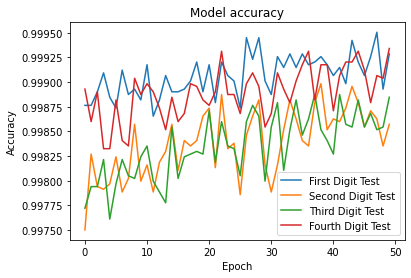

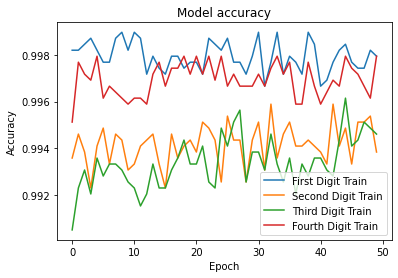

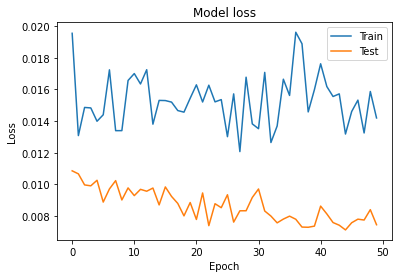

In [49]:
plot_diagram(
    
    [history.history['digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    [history.history['val_digit%d_accuracy' % i] for i in range(NUM_OF_LETTERS)],
    history.history['loss'],
    history.history['val_loss'],
)

In [50]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Qwerty\Downloads\captcha_solver\saved_models\keras_cifar10_trained_4digits_model.h5 


In [51]:
# Score trained model.
scores = model.evaluate(x_train, s_train, verbose=1)
print('Train loss:     %f' % np.mean(scores[0:NUM_OF_LETTERS]))
acc = 1.
for i in range(NUM_OF_LETTERS):
    acc *= scores[NUM_OF_LETTERS+1+i]
print('Train accuracy: %.2f' % (acc * 100.))

1139/1139 [==============================] - 9s 8ms/step - loss: 2.1255e-04 - digit0_loss: 2.9262e-05 - digit1_loss: 6.1458e-05 - digit2_loss: 9.1630e-05 - digit3_loss: 3.0196e-05 - digit0_accuracy: 1.0000 - digit1_accuracy: 1.0000 - digit2_accuracy: 1.0000 - digit3_accuracy: 1.0000
Train loss:     0.000099
Train accuracy: 99.99


In [52]:
scores = model.evaluate(x_test, s_test, verbose=1)
print('Test loss:     %f' % np.mean(scores[0:NUM_OF_LETTERS]))
acc = 1.
for i in range(NUM_OF_LETTERS):
    acc *= scores[NUM_OF_LETTERS+1+i]
print('Test accuracy: %.2f' % (acc * 100.))

122/122 [==============================] - 1s 9ms/step - loss: 0.0142 - digit0_loss: 0.0024 - digit1_loss: 0.0051 - digit2_loss: 0.0049 - digit3_loss: 0.0019 - digit0_accuracy: 0.9979 - digit1_accuracy: 0.9938 - digit2_accuracy: 0.9946 - digit3_accuracy: 0.9979
Test loss:     0.006631
Test accuracy: 98.44
